In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


In [2]:
trace_df = pd.read_feather('/traces/canneal/train.feather')
train_df = trace_df[:200000]
dev_df = trace_df[200000:][:200000]


In [3]:
train_addr = train_df['addr_int'].to_numpy()
train_deltas = train_addr[1:] - train_addr[:-1]
dev_addr = dev_df['addr_int'].to_numpy()
dev_deltas = dev_addr[1:] - dev_addr[:-1]


In [4]:
tr_unique, tr_count = np.unique(train_deltas, return_counts=True)
tr_stacked = np.column_stack((tr_unique, tr_count))
tr_unique_filtered = tr_stacked[tr_stacked[:, 1] >= 10][:, 0]
print('Number of unique deltas:', len(tr_unique))
print('Number of unique filtered deltas:', len(tr_unique_filtered))


Number of unique deltas: 31039
Number of unique filtered deltas: 177


In [5]:
tr_most_common = tr_stacked[np.argsort(tr_stacked[:, 1])][-50000:][:, 0]
num_out_deltas = len(tr_most_common)
print('Number of output deltas:', num_out_deltas)


Number of output deltas: 31039


In [6]:
dummy_delta = tr_unique_filtered.max() + 1
feature_enc = OrdinalEncoder()
labels_enc = OrdinalEncoder()
feature_enc.fit(np.append(tr_unique_filtered, dummy_delta).reshape(-1, 1))
labels_enc.fit(np.append(tr_most_common, dummy_delta).reshape(-1, 1))


OrdinalEncoder()

In [7]:
def window_enc(series, look_back):
    # Windowing the series
    to_ret = []
    for t in range(len(series) - look_back):
        to_ret.append(series[t:t+look_back+1].tolist())
    wdata = np.array(to_ret)
    # Get features and labels
    features = wdata[:, :look_back].reshape(-1, 1)
    labels = wdata[:, look_back].reshape(-1, 1)
    # Set dummy deltas
    features[~np.in1d(features, tr_unique_filtered)] = dummy_delta # replace rare deltas from features
    labels[~np.in1d(labels, tr_most_common)] = dummy_delta # replace deltas not included in out vocab
    # Ordinal encoding
    features = feature_enc.transform(features)
    labels = labels_enc.transform(labels)
    return features.reshape(-1, look_back), to_categorical(labels.reshape(1, -1)[0], num_classes=num_out_deltas+1)

look_back = 3
train_x, train_y = window_enc(train_deltas, look_back)
dev_x, dev_y = window_enc(dev_deltas, look_back)


In [8]:
i = Input(shape=(look_back,))
x = Embedding(int(train_x.max()) + 1, 10, input_length=look_back)(i)
x = LSTM(50)(x)
x = Dropout(0.1)(x)
x = Dense(num_out_deltas+1, activation='softmax')(x)


In [9]:
model = Model(i, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


In [10]:
r = model.fit(
    train_x, train_y, 
    validation_data=(dev_x, dev_y),
    epochs=20,
    shuffle=False,
    batch_size=256
)


Epoch 1/20
782/782 [==============================] - 62s 79ms/step - loss: 6.4661 - accuracy: 0.1609 - val_loss: 6.0590 - val_accuracy: 0.1963
Epoch 2/20
782/782 [==============================] - 62s 80ms/step - loss: 5.0531 - accuracy: 0.3545 - val_loss: 4.7897 - val_accuracy: 0.5034
Epoch 3/20
782/782 [==============================] - 62s 79ms/step - loss: 3.9665 - accuracy: 0.5536 - val_loss: 4.4672 - val_accuracy: 0.5858
Epoch 4/20
782/782 [==============================] - 58s 74ms/step - loss: 3.5733 - accuracy: 0.6001 - val_loss: 4.5468 - val_accuracy: 0.6049
Epoch 5/20
782/782 [==============================] - 56s 71ms/step - loss: 3.3745 - accuracy: 0.6135 - val_loss: 4.6928 - val_accuracy: 0.6126
Epoch 6/20
782/782 [==============================] - 58s 74ms/step - loss: 3.2367 - accuracy: 0.6163 - val_loss: 4.8205 - val_accuracy: 0.6136
Epoch 7/20
782/782 [==============================] - 62s 79ms/step - loss: 3.1352 - accuracy: 0.6175 - val_loss: 4.9418 - val_accuracy:

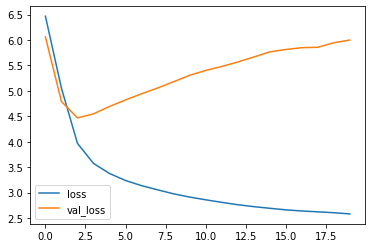

In [11]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


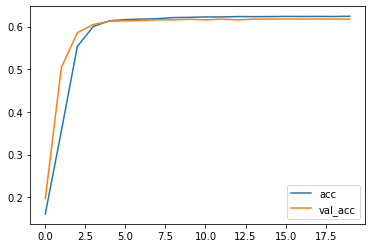

In [12]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
